# <span style="color:purple">Clustering: </span><span>Finding Restaurant Clusters for Retail Site Selection</span>

![clustering](img/restaurants_clustering_v2.gif "Density-based Clustering")


## An Example of Spatial Analysis in ArcGIS Using Density-based Clustering 

Prospecting a successful retail location often requires a thorough understanding of where people shop, dine, and linger for entertainment in a study area. One useful way to start making sense of the vast quantities of retail business information and start finding the locations that matter is to use spatial clustering to find locations with a dense retail presence. 

This example starts with retail business data in Pittsburgh, PA and leverages a couple of Spatial Statistics tools in ArcGIS ([Density-based Clustering](http://pro.arcgis.com/en/pro-app/tool-reference/spatial-statistics/densitybasedclustering.htm), [Directional Distribution (Standard Deviational Ellipse)](http://pro.arcgis.com/en/pro-app/tool-reference/spatial-statistics/directional-distribution.htm)) to separate the dense retail  data into defined cluster locations which can then be the target of further analysis and potential decisions for your organization. 

## Steps

This is a basic example that will cover the following steps:

1) Retrieve Pittsburgh restaurants data.


2) Explore the data through tables, charts, and maps.


3) Perform spatial analysis:

    Finding Restaurant Zones through Clustering

    - Density-based Clustering
    - Directional Distribution (Standard Deviational Ellipse)

    Prioritizing Restaurant Zones
    
    - Aggregated sales volume per ellipse zone
    - Density of Hot Spot restaurants in the ellipse zone

4) Present Results.

## General Workflow

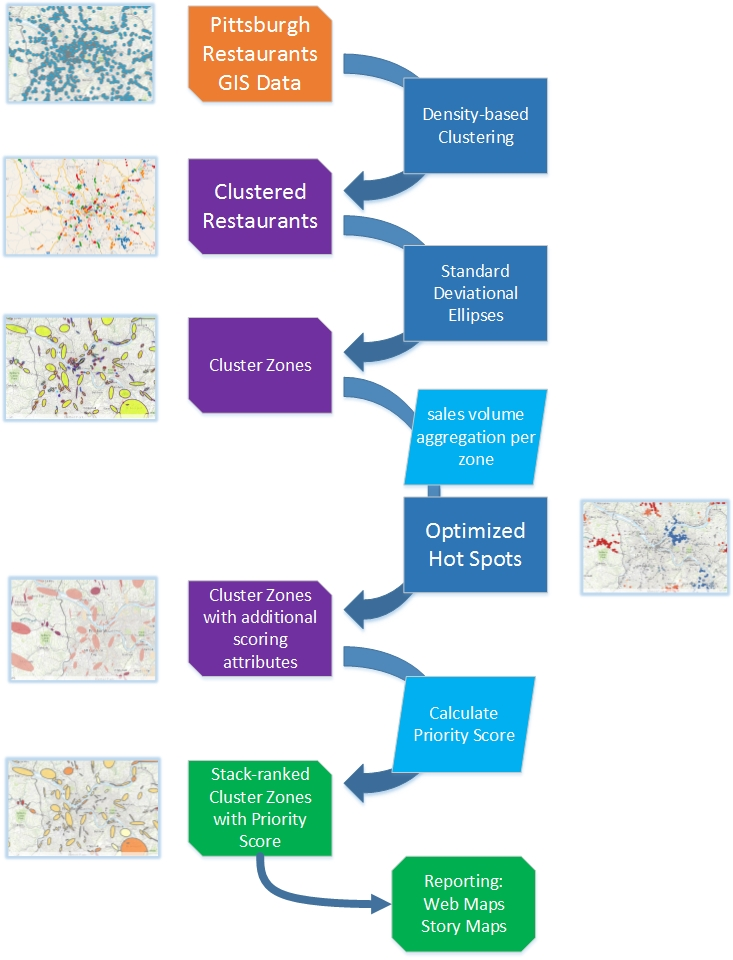

### Preliminary Setup

#### Import the needed modules, including ArcPy, the ArcGIS API for Python, and other useful modules

In [1]:
import arcpy
arcpy.env.overwriteOutput = True
import arcgis
from arcgis import features
import pandas as pd
from arcgis.features import GeoAccessor, GeoSeriesAccessor
from arcgis.geoenrichment import *
from arcgis.geometry import project
import os
import time

In [2]:
# Imports for plotting in Bokeh
import numpy as np
import bokeh
from bokeh.io import output_notebook, output_file, show
from bokeh.plotting import figure
from bokeh.models import Legend, Range1d
from bokeh.embed import file_html
from bokeh.resources import CDN
# Set bokeh to output plots in the notebook
output_notebook()

Loading BokehJS ...

In [3]:
gis = arcgis.gis.GIS("home", verify_cert=False)

In [4]:
# Create a helper function that receives a spatially-enabled dataframe and column as input, and returns a map widget, symbolized layer, and bokeh histogram using the layer's colormap
def create_map_and_histogram(map_location, sdf, column, method='esriClassifyNaturalBreaks', class_count=5, cmap='OrRd', alpha=0.8, plot_height=600, plot_width=600):
    """
    create_map_and_histogram
    inputs:
        map_location: Location for the map widget. The entry will be geocoded and used as the starting extent for the map widget. Example: "Pittsburgh"
        sdf: spatially-enabled dataframe that is plotted on a map and histogram
        column: column to use for layer symbology and histogram
    return: map widget, bokeh plot
    """
    
    # Create map
    map_obj = gis.map(map_location)
    sdf.spatial.plot(map_widget=map_obj, renderer_type='c', method=method, class_count=class_count, col=column, cmap=cmap, alpha=0.8)  
    
    # Extract the layer's class breaks and colors
    class_breaks = map_obj.layers[0].layer.layerDefinition.drawingInfo.renderer.classBreakInfos
    cbs_list = []
    cmap_list = []
    for cb in class_breaks:
        cbs_list.append(cb.classMaxValue)
        cmap_list.append('#%02x%02x%02x' % (cb.symbol.color[0], cb.symbol.color[1], cb.symbol.color[2]))
    
    # Create a histogram of salesvol values
    hist, edges = np.histogram(sdf[column],
                              bins=class_count)

    # Put the information in a dataframe
    hist_df = pd.DataFrame({column: hist,
                            'left': edges[:-1],
                            'right': edges[1:]})
    
    # Add colors to each hist_df record
    hist_df['color'] = pd.Series(cmap_list)

    # Create the blank plot
    p = figure(plot_height = plot_height, plot_width = plot_width, 
               title = 'Histogram',
               y_axis_label = 'Feature Count',
               x_axis_label = column)

    # Add a quad glyph
    p.quad(bottom=0, top=hist_df[column], 
           left=hist_df['left'], right=hist_df['right'],
           line_color='white', fill_color=hist_df['color'])

    # Return outputs
    return map_obj, p

In [5]:
# Helper functions to change the extent of a web map based on ellipse centroids
def return_center_dict(centerx, centery):
    center_shape_dict = {}
    center_shape_dict['spatialReference'] = {'latestWkid': 3857, 'wkid': 102100}
    center_shape_dict['x'] = centerx
    center_shape_dict['y'] = centery
    return center_shape_dict

def visit_sites(m, points, timesleep, zoom_level=15):
    m.zoom = zoom_level
    i = 0
    for i in range(len(points)):
        m.center = [points[i]['y'], points[i]['x']]
        time.sleep(timesleep)
        
def visit_ellipse_features_on_map_widget(map_obj, sdf, zoom_level=15, number_of_records=None, timesleep=5):
    """
    """
    # Create a center_xy column from the sdf
    sdf['center_xy'] = sdf.apply(lambda x: return_center_dict(x['centerx'], x['centery']), axis=1)
    if number_of_records:
        sitelist = sdf.head(number_of_records)['center_xy'].tolist()
    else:
        sitelist = sdf.head()['center_xy'].tolist()
    xys = project(sitelist, in_sr=3857, out_sr=4326)
    visit_sites(map_obj, xys, timesleep)        

# <span style="color:purple">1) Retrieve Pittsburgh restaurants data</span>

We published an item containing Pittsburgh restaurants to the ArcGIS Enterprise. Let's find this item using the "Add" toolbar and load it into our notebook as an item variable.

In [8]:
# Item Added From Toolbar
# Title: Restaurant Points v1 | Type: Feature Service | Owner: anieto001
restaurants_item = gis.content.get("bb8eefe085fe4ab08e920bc67e5bde6a")
restaurants_item

<Item title:"Restaurant Points v1" type:Feature Layer Collection owner:anieto001>

The spatially-enabled dataframe helps us explore the data in a tabular format by leveraging the Pandas library.

In [9]:
restaurants_sdf = pd.DataFrame.spatial.from_layer(restaurants_item.layers[0])
restaurants_sdf.head()

,SHAPE,city,coname,empnum,frncod,hdbrch,iscode,loc_name,locnum,naics,...,score,sic,source,sqftcode,state,state_name,status,street,zip,zip4
0,"{""x"": -8919964.005599998, ""y"": 4867758.9117000...",MARIANNA,RUDNICK'S,6.0,,,3,StreetAddress,402036338,72251117,...,100.0000,581208,INFOGROUP,A,PA,Pennsylvania,M,TEN MILE RD,15345,1080
1,"{""x"": -8905258.700800002, ""y"": 4865826.0264, ""...",FREDERICKTOWN,RIVERSIDE INN,5.0,,,,StreetAddress,387410335,72251117,...,90.0938,581208,INFOGROUP,A,PA,Pennsylvania,M,FRONT ST,15333,
2,"{""x"": -8905314.3606, ""y"": 4866727.023800001, ""...",FREDERICKTOWN,RIVIERA RESTAURANT LOUNGE,5.0,,,,StreetAddress,831505334,72251117,...,100.0000,581208,INFOGROUP,A,PA,Pennsylvania,M,FRONT ST,15333,
3,"{""x"": -8904590.783900002, ""y"": 4868224.0231000...",BETHLEHEM,KUKI CHINESE RESTAURANT,3.0,,,C,PointAddress,907890941,72251117,...,86.8281,581208,INFOGROUP,A,PA,Pennsylvania,M,E 3RD ST,18015,1306
4,"{""x"": -8896241.822100002, ""y"": 4844052.5718000...",MASONTOWN,DOLFI'S,10.0,,,,StreetAddress,309912996,72251117,...,100.0000,581208,INFOGROUP,B,PA,Pennsylvania,M,RIVER AVE,15461,1551


We're also going to temporarily store this spatially-enabled dataframe as a feature class in order to run arcpy operations on the data

In [10]:
# Create file geodatabase
fgdb = arcpy.CreateFileGDB_management(out_folder_path=r'/mnt/arcgis/me', out_name="pittsburgh_restaurants.gdb").getOutput(0)
fgdb

'/mnt/arcgis/me/pittsburgh_restaurants.gdb'

In [11]:
# Use the spatially-enabled dataframe's to_featureclass method to convert to a feature class
fc = restaurants_sdf.spatial.to_featureclass(os.path.join(fgdb, "restaurants_pittsburgh"))
fc

'/mnt/arcgis/me/pittsburgh_restaurants.gdb/restaurants_pittsburgh'

In [12]:
# Confirm it exists after converting it
arcpy.Exists(fc)

True

# <span style="color:purple">2) Explore the data through tables, charts, and maps.</span>

In [13]:
# Get the amount of records and columns in our data
print("Amount of restaurants: {0}\nAmount of attributes: {1}".format(restaurants_sdf.shape[0], restaurants_sdf.shape[1]))

Amount of restaurants: 5026
Amount of attributes: 22


In [14]:
# Get summary statistics on numeric fields
restaurants_sdf.describe()

,empnum,objectid,salesvol,score
count,5026.000000,5026.000000,5026.000000,5026.000000
mean,17.216076,2513.500000,802.645444,99.608847
std,24.190230,1451.025557,1130.667265,1.855258
min,1.000000,1.000000,0.000000,85.703100
25%,6.000000,1257.250000,280.000000,100.000000
50%,8.000000,2513.500000,374.000000,100.000000
75%,19.000000,3769.750000,888.000000,100.000000
max,300.000000,5026.000000,14035.000000,100.000000



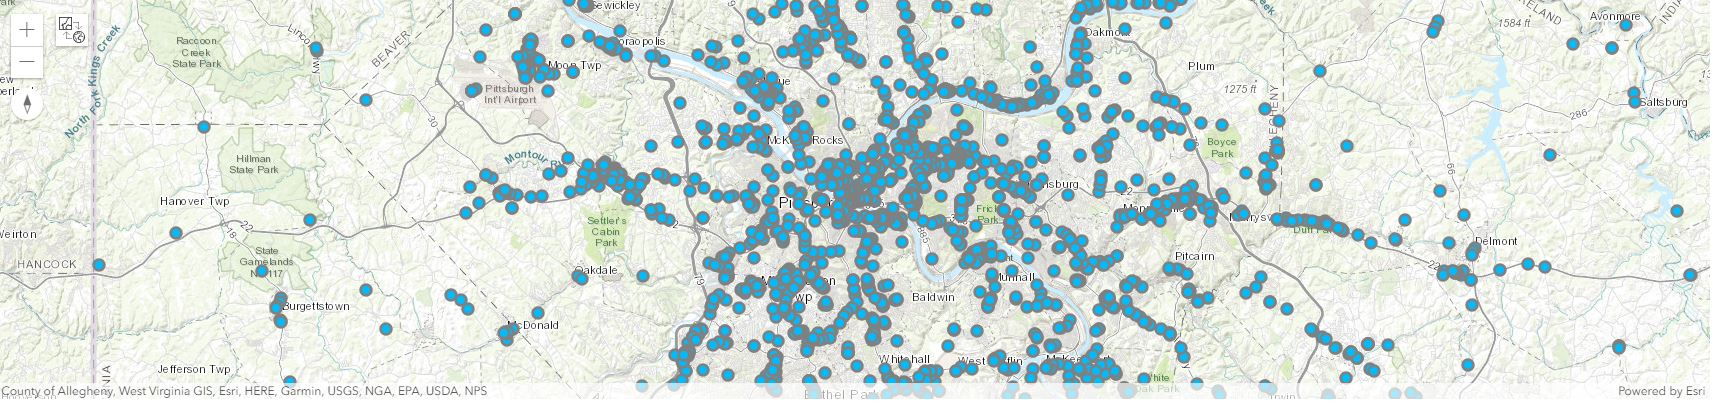

In [19]:
# Get a basic map of the restaurant locations as points
restaurants_map = gis.map("Pittsburgh")
restaurants_sdf.spatial.plot(map_widget=restaurants_map)
restaurants_map


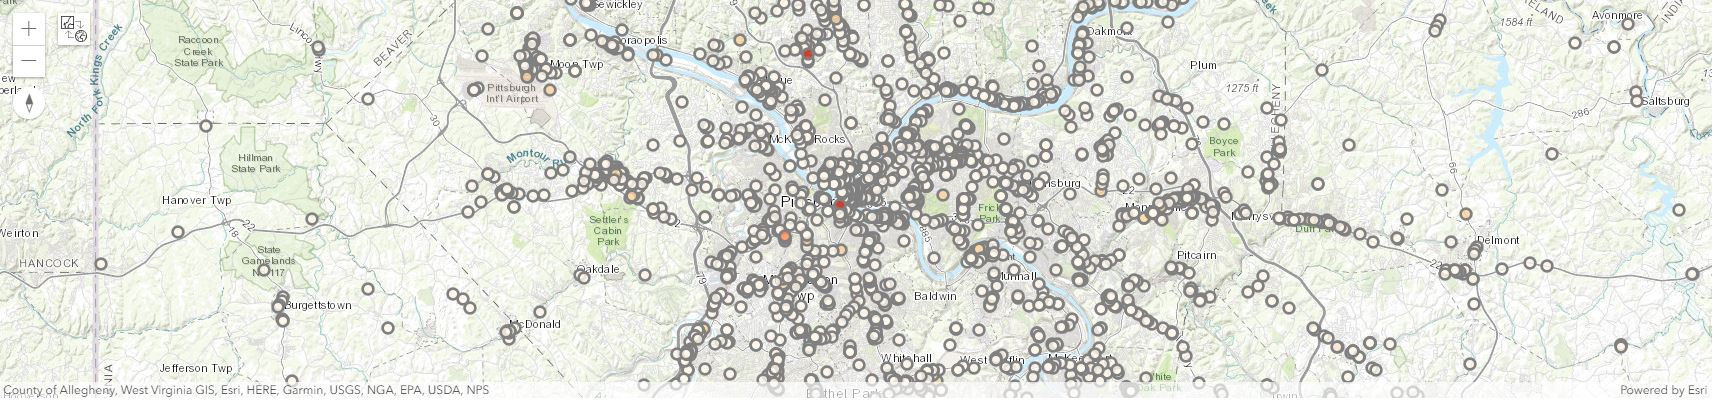

In [21]:
# Use our helper function to show a map and histogram of restaurants symbolized by sales volume 
restaurants_map, sales_hist = create_map_and_histogram("Pittsburgh", restaurants_sdf, "salesvol")
restaurants_map

In [22]:
show(sales_hist)

See https://mybinder.org/v2/gh/bokeh/bokeh-notebooks/master?filepath=tutorial%2F00%20-%20Introduction%20and%20Setup.ipynb for a guide to Bokeh's plotting capabilities

## What are the top five restaurants by sales volume?

In [23]:
# Get the restaurants with the highest sales revenue by sorting on the 'SALESVOL' column
top_sales_sdf = restaurants_sdf.sort_values(by=['salesvol'], ascending=False).reset_index()
top_five_sdf = top_sales_sdf.head()

print("Top 5 Restaurants in Pittsburgh by Sales Volume: ")
top_five_sdf[['coname', 'salesvol', 'street', 'city', 'state', 'state_name', 'zip']]

Top 5 Restaurants in Pittsburgh by Sales Volume: 


,coname,salesvol,street,city,state,state_name,zip
0,CHEESECAKE FACTORY,14035.0,ROSS PARK MALL DR,PITTSBURGH,PA,Pennsylvania,15237
1,EAT'N PARK,12865.0,PARK MANOR DR,PITTSBURGH,PA,Pennsylvania,15205
2,CHEESECAKE FACTORY,12631.0,S 27TH ST,PITTSBURGH,PA,Pennsylvania,15203
3,M I FRIDAY,11695.0,PERRY HWY,PITTSBURGH,PA,Pennsylvania,15229
4,NANA,11695.0,WATERFRONT DR,PITTSBURGH,PA,Pennsylvania,15222


In [24]:
# Create a basic chart of the top five restaurants by sales volume
label = top_five_sdf['street'].tolist()
value = top_five_sdf['salesvol'].tolist()

p = figure(x_range=label,
           title = 'Top Five Restaurants by Sales Volume',
           x_axis_label = 'Restaurant Address',
           y_axis_label = 'Sales volume in thousands of dollars')
p.xaxis.major_label_orientation = np.pi/4

p.vbar(x=label, top=value, width=0.5)

show(p)


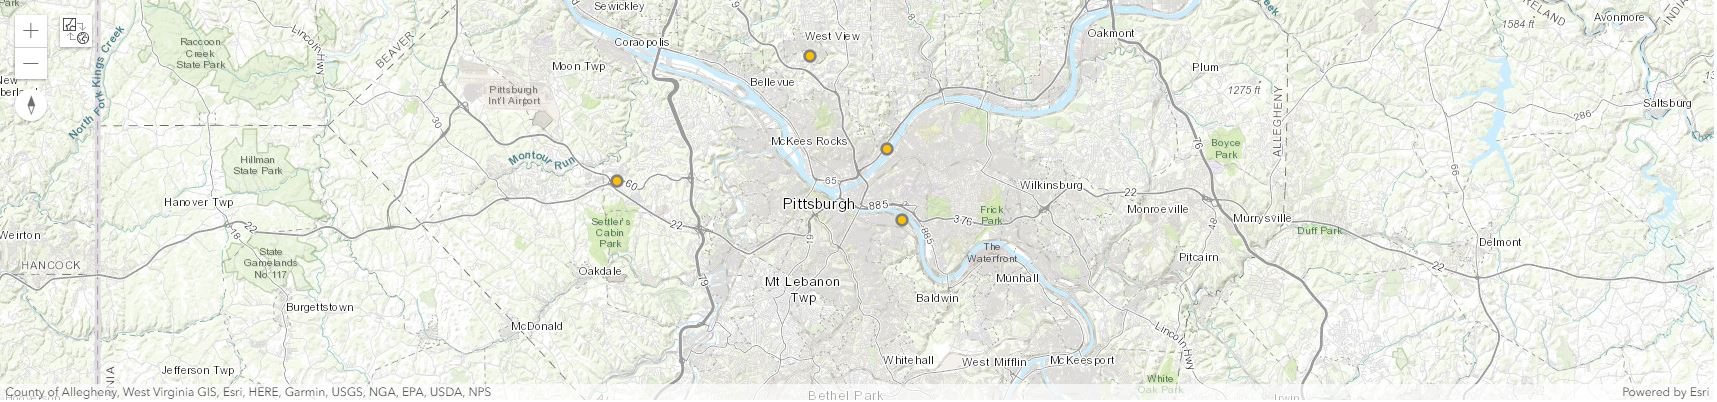

In [26]:
# Plot the highest five selling restaurants
top_five_restaurants_map = gis.map("Pittsburgh")
top_five_sdf.spatial.plot(map_widget=top_five_restaurants_map)
top_five_restaurants_map

## What are the top five zip codes by sales volume?

In [27]:
# Determine the top five zip codes by average restaurant sales volume

# Use groupby object to make calculations by Zip Code
zip_groupby = restaurants_sdf.groupby(restaurants_sdf['zip'])
# Determine means for numeric columns by zip
zip_mean_sales_df = zip_groupby.mean().sort_values(by=['salesvol'], ascending=False)
# Calculate Zip ranks by average sales volume
zip_mean_sales_df['Zip Ave. Sales Rank'] = zip_mean_sales_df['salesvol'].rank(ascending=False)
# Drop the unneeded 'SCORE' field
del zip_mean_sales_df['score']

zip_mean_sales_df.head()

,empnum,objectid,salesvol,Zip Ave. Sales Rank
zip,,,,
15231,39.818182,4293.818182,1862.272727,1.0
15275,38.521739,3861.695652,1801.652174,2.0
15482,35.000000,950.000000,1637.000000,3.0
15084,32.605263,1093.789474,1524.842105,4.0
15205,30.424779,3716.203540,1422.796460,5.0


In [28]:
# Create a basic chart of the top five zip codes by sales volume
label = list(zip_mean_sales_df.head().index.values)
value = list(zip_mean_sales_df['salesvol'].head())

p = figure(x_range=label,
           title = 'Top Five Zip Codes by Mean Sales Volume',
           x_axis_label = 'Zip Code',
           y_axis_label = 'Average Sales volume in thousands of dollars')
p.xaxis.major_label_orientation = np.pi/4

p.vbar(x=label, top=value, width=0.5)

show(p)

In [29]:
# Load the geoenrichment module's country object for the US, and pre-cache some geometry
usa = Country.get("United States")
usa.subgeographies.states['Pennsylvania'].zip5['15275'].geometry

{'rings': [[[-80.20510177197895, 40.46367809284811],
   [-80.20285000000538, 40.464249999514806],
   [-80.2024476590743, 40.461483705836685],
   [-80.19889047299921, 40.45980803625618],
   [-80.1915099992887, 40.458040000417576],
   [-80.19025999991791, 40.458729999882856],
   [-80.1822480065078, 40.45502180658601],
   [-80.17774177478417, 40.45432623157046],
   [-80.17389723916088, 40.45503225869422],
   [-80.17209999967325, 40.45352999976287],
   [-80.1718008488814, 40.45158457909381],
   [-80.17001734741763, 40.45118836250693],
   [-80.16895809843734, 40.4497721307695],
   [-80.17200000037039, 40.449139999580176],
   [-80.1767143003178, 40.44507909347006],
   [-80.18374402816681, 40.44449852306094],
   [-80.18682865784238, 40.44828075360781],
   [-80.18712000042767, 40.45099000006832],
   [-80.1909970157469, 40.450595480067825],
   [-80.19070562375396, 40.44787582669217],
   [-80.19523184940925, 40.45230015926403],
   [-80.19687959659564, 40.452322112927924],
   [-80.19693000049155,


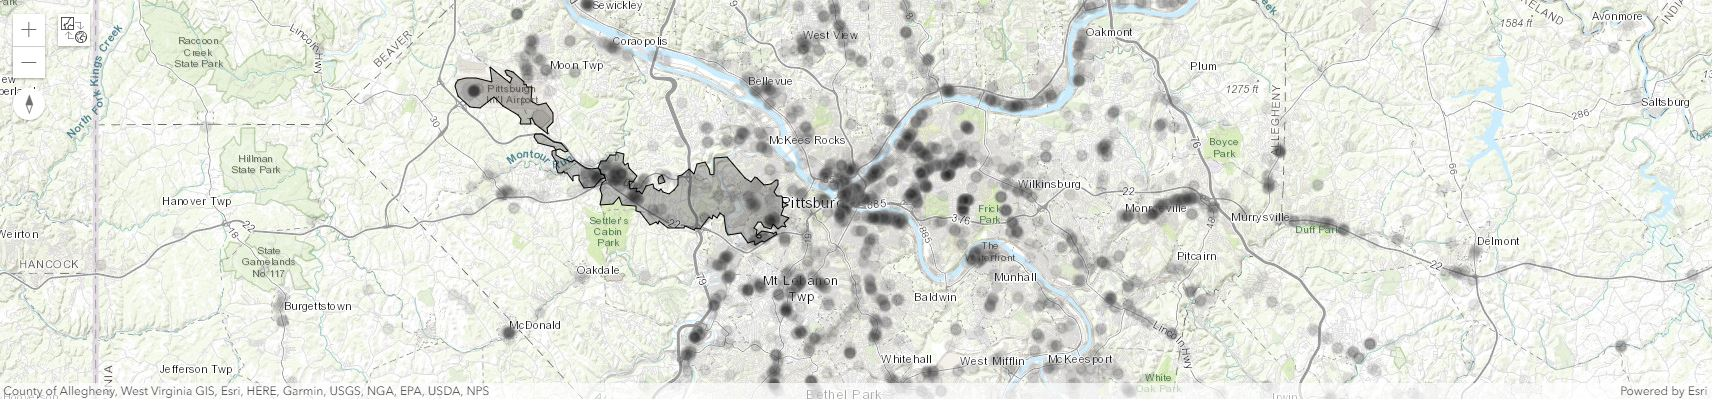

In [31]:
# Create a basic map showing the top five zip codes
top_five_zip_map = gis.map("Pittsburgh")
for zip5 in zip_mean_sales_df.head().index.values.tolist():
    top_five_zip_map.draw(usa.subgeographies.states['Pennsylvania'].zip5[str(zip5)].geometry)
restaurants_sdf.spatial.plot(map_widget=top_five_zip_map, alpha=0.1, cmap='Greys', outline_color='Greys')
top_five_zip_map 

# <span style="color:purple">3) Perform spatial analysis</span> 

To help us identify potential sites for further analysis, we will leverage spatial clustering to find locations with dense retail presence. In this case, Density-based Clustering and Directional Distribution are very useful to help us identify these potential sites. 

## Density-based Clustering

![clustering](https://github.com/Qberto/arcgispythonapi_arcpy-spatial_statistics_examples/raw/5f8994ab80301d8ae145e9081b16c1389a5729d0/img/dbclustering_01.png "Density-based Clustering")

The [Density-based Clustering tool](http://pro.arcgis.com/en/pro-app/tool-reference/spatial-statistics/how-density-based-clustering-works.htm) works by detecting areas where points are concentrated and where they are separated by areas that are empty or sparse. Points that are not part of a cluster are labeled as noise.

This tool uses unsupervised machine learning clustering algorithms which automatically detect patterns based purely on spatial location and the distance to a specified number of neighbors. These algorithms are considered unsupervised because they do not require any training on what it means to be a cluster.

#### Three clustering algorithms:

The Density-based Clustering tool provides three different Clustering Methods with which to find clusters in your point data:

- _Defined distance (DBSCAN)_ — Uses a specified distance to separate dense clusters from sparser noise. The DBSCAN algorithm is the fastest of the clustering methods, but is only appropriate if there is a very clear Search Distance to use, and that works well for all potential clusters. This requires that all meaningful clusters have similar densities.

- _Self-adjusting (HDBSCAN)_ — Uses a range of distances to separate clusters of varying densities from sparser noise. The HDBSCAN algorithm is the most data-driven of the clustering methods, and thus requires the least user input.

- _Multi-scale (OPTICS)_ — Uses the distance between neighboring features to create a reachability plot which is then used to separate clusters of varying densities from noise. The OPTICS algorithm offers the most flexibility in fine-tuning the clusters that are detected, though it is computationally intensive, particularly with a large Search Distance.

In [32]:
# Set an output path name
output_path = "{0}//{1}_HDBSCAN".format(fgdb, "RestaurantClusters")
clusters_fc = arcpy.stats.DensityBasedClustering(fc, output_path, "HDBSCAN", 5)
clusters_fc

<Result '/mnt/arcgis/me/pittsburgh_restaurants.gdb/RestaurantClusters_HDBSCAN'>

In [33]:
# Convert the clusters feature class from Density-based Clustering into a spatially-enabeled dataframes (one for clusters, one for noise)
dbclustering_sdf = pd.DataFrame.spatial.from_featureclass(clusters_fc)
clusters_sdf = dbclustering_sdf.loc[dbclustering_sdf['CLUSTER_ID'] != -1]
noise_sdf = dbclustering_sdf.loc[dbclustering_sdf['CLUSTER_ID'] == -1]
clusters_sdf.head()

,OBJECTID,SOURCE_ID,CLUSTER_ID,PROB,OUTLIER,EXEMPLAR,STABILITY,COLOR_ID,SHAPE
3,4,4,56,0.173037,0.826963,0,0.0,8,"{""x"": -8904590.7839, ""y"": 4868224.023100004, ""..."
4,5,5,36,1.000000,0.000000,1,0.0,4,"{""x"": -8896241.8221, ""y"": 4844052.571800001, ""..."
5,6,6,36,1.000000,0.000000,1,0.0,4,"{""x"": -8895774.2802, ""y"": 4844531.075199999, ""..."
6,7,7,36,1.000000,0.000000,1,0.0,4,"{""x"": -8894527.5019, ""y"": 4845430.143799998, ""..."
7,8,8,36,0.790149,0.209851,0,0.0,4,"{""x"": -8893759.3974, ""y"": 4846532.338799998, ""..."


In [34]:
noise_sdf.head()

,OBJECTID,SOURCE_ID,CLUSTER_ID,PROB,OUTLIER,EXEMPLAR,STABILITY,COLOR_ID,SHAPE
0,1,1,-1,0.0,0.027113,0,0.0,-1,"{""x"": -8919964.0056, ""y"": 4867758.911700003, ""..."
1,2,2,-1,0.0,0.023014,0,0.0,-1,"{""x"": -8905258.7008, ""y"": 4865826.0264, ""spati..."
2,3,3,-1,0.0,0.005891,0,0.0,-1,"{""x"": -8905314.3606, ""y"": 4866727.023800001, ""..."
12,13,13,-1,0.0,0.011129,0,0.0,-1,"{""x"": -8893403.1751, ""y"": 4859869.875299998, ""..."
26,27,27,-1,0.0,0.255119,0,0.0,-1,"{""x"": -8878608.8147, ""y"": 4851827.477499999, ""..."


Let's take a look at the outputs of Density-based Clustering on a map


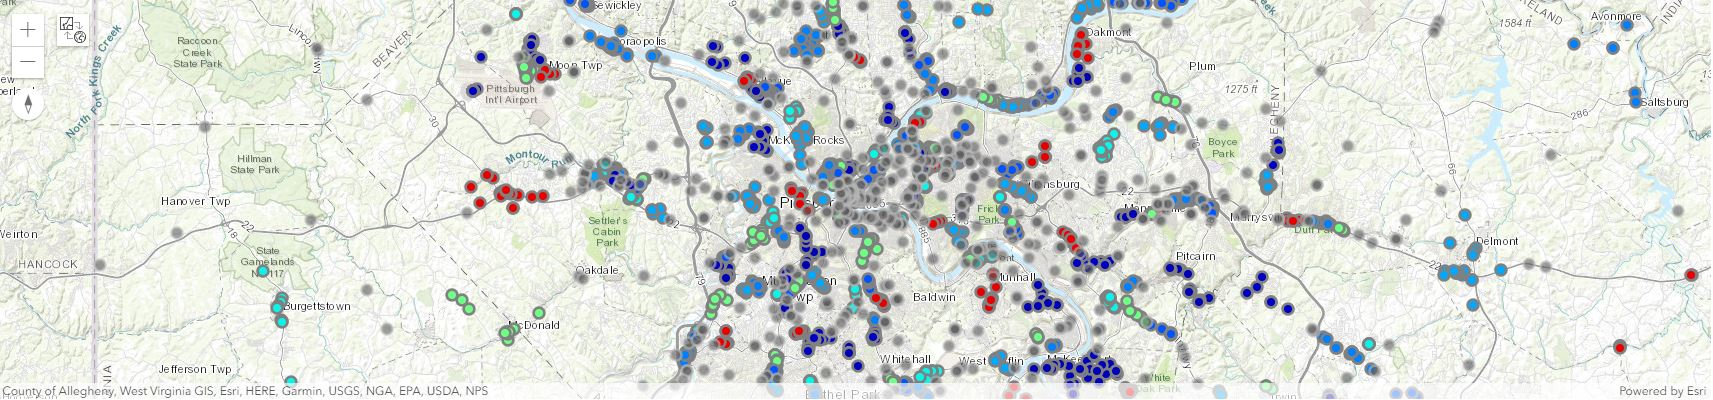

In [40]:
# Visualize both clusters and noise
results_map = gis.map("Pittsburgh")
clusters_sdf.spatial.plot(map_widget=results_map, renderer_type='u', col="COLOR_ID")
noise_sdf.spatial.plot(map_widget=results_map, cmap='Greys', alpha=0.6, outline_color='Greys')
results_map


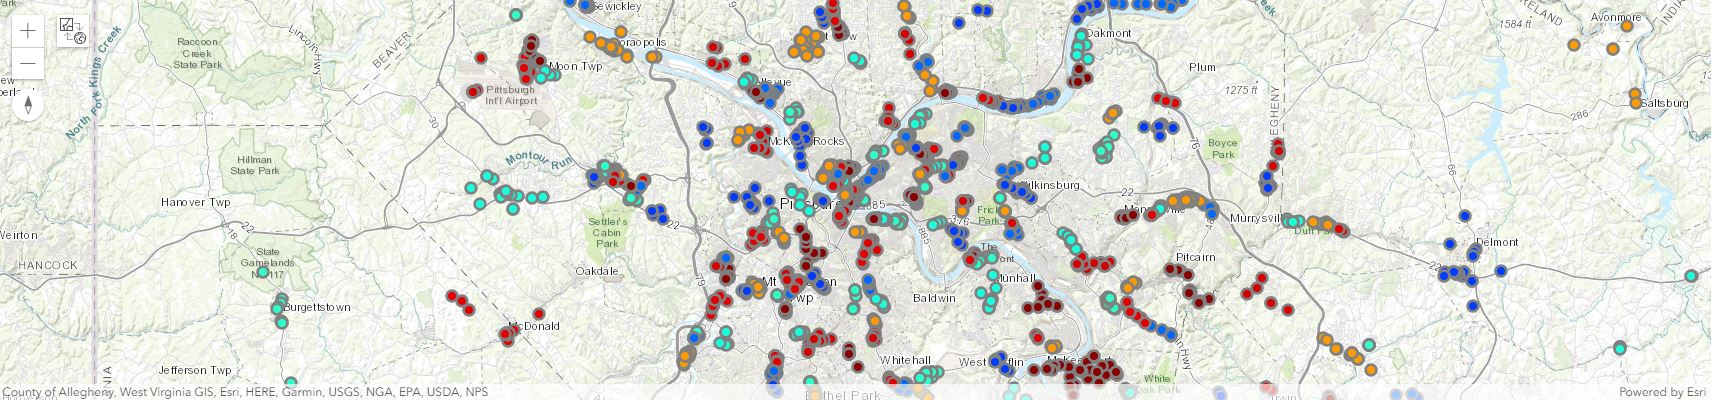

In [41]:
# Visualize only clusters
onlyclusters_map = gis.map("Pittsburgh")
clusters_sdf.spatial.plot(map_widget=onlyclusters_map, renderer_type='u', col="COLOR_ID")
onlyclusters_map

## Directional Distribution (Standard Deviational Ellipse)

![ellipses](https://github.com/Qberto/arcgispythonapi_arcpy-spatial_statistics_examples/raw/5f8994ab80301d8ae145e9081b16c1389a5729d0/img/ellipses_01.png "Standard Deviational Ellipses") 

While you can get a sense of the location of the clusters by running Density-based Clustering and drawing output cluster features on a map, calculating the standard deviational ellipses for each cluster makes the clusters a bit clearer. Since this workflow needs zones to evaluate rather than specific restaurants, the ellipses can be the new target of our analysis. Let's run the tool from this hosted notebook.

In [42]:
# Run Directional Distribution using clusters as an input
clusters_fc = clusters_sdf.spatial.to_featureclass(fgdb+"//restaurant_clusters")
ellipses = arcpy.DirectionalDistribution_stats(clusters_fc, fgdb+"//cluster_ellipses", Ellipse_Size="2 standard deviations", Case_Field="CLUSTER_ID").getOutput(0)
ellipses_sdf = pd.DataFrame.spatial.from_featureclass(ellipses)
ellipses_sdf.head()

,OBJECTID,CenterX,CenterY,XStdDist,YStdDist,Rotation,CLUSTER_ID,SHAPE
0,1,-8.910530e+06,5.023269e+06,2151.586100,12525.834221,22.711797,1,"{""rings"": [[[-8912514.4278, 5024099.286899999]..."
1,2,-8.825619e+06,4.985812e+06,11059.807891,19222.922180,23.821812,2,"{""rings"": [[[-8835736.6028, 4990278.838500001]..."
2,3,-8.831966e+06,4.966738e+06,283.002577,4506.261331,143.274423,3,"{""rings"": [[[-8832192.7771, 4966569.239699997]..."
3,4,-8.847666e+06,4.849466e+06,3419.763571,13281.725110,19.417593,4,"{""rings"": [[[-8850890.9565, 4850602.765900001]..."
4,5,-8.875420e+06,5.007396e+06,3412.772598,12791.984258,14.330382,5,"{""rings"": [[[-8878726.6002, 5008240.671899997]..."


In [43]:
print("Produced {0} ellipses.".format(ellipses_sdf.shape[0]))

Produced 346 ellipses.



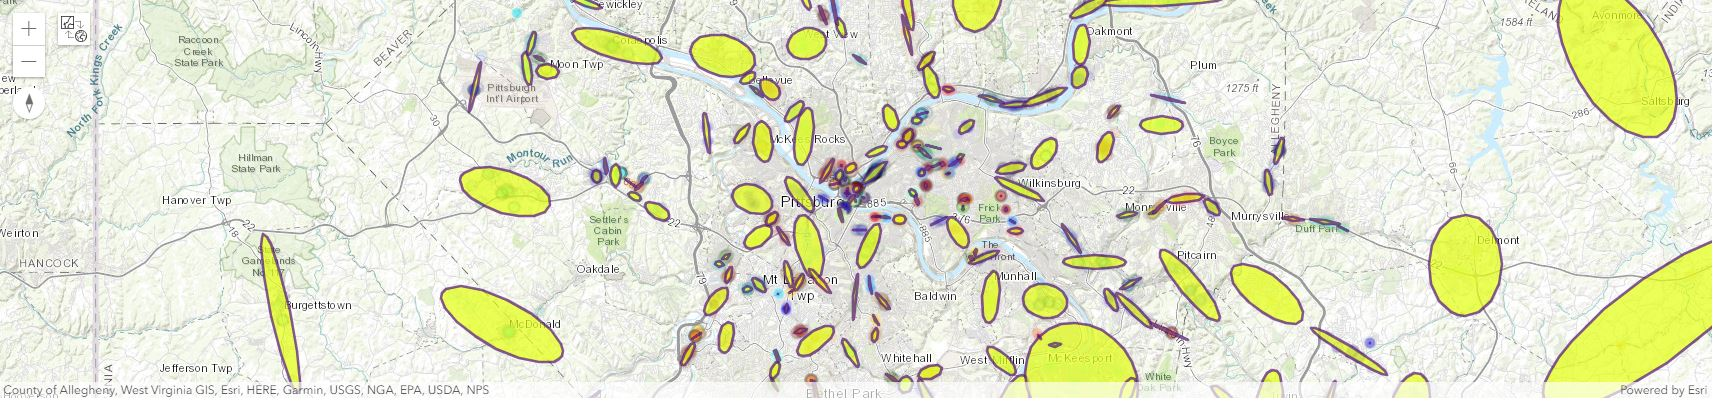

In [46]:
ellipses_map = gis.map("Pittsburgh")
clusters_sdf.spatial.plot(map_widget=ellipses_map, renderer_type='u', col='CLUSTER_ID', alpha=0.1, outline_color='Greys')
ellipses_sdf.spatial.plot(map_widget=ellipses_map, alpha=0.7, outline_color='magma')
ellipses_map

## Where are the most important ellipse zones that we should first prioritize? 

We have progressed from a point map of thousands of restaurants throughout Pittsburgh to 346 ellipse zones derived from density-based clustering of restaurants. To help prioritize the evaluation of these areas, let's bring additional data and analysis that can help us rank these zones and help organizations understand which areas they should first be examining. 

We'll use two components to evaluate each ellipse zone:

A. Aggregated sales volume per ellipse zone

B. Density of Hot Spot restaurants in the ellipse zone

### A. Calculating total and average sales volume per ellipse zone

The first criteria for evaluating each ellipse zone will the total and average sales volume of the restaurant locations that defined the cluster zone. This is a basic evaluation of the overall commercial performance of the restaurants in each area. To perform this calculation, we'll use the active GIS to run the "aggregate_points" tool to calculate basic sums and means for a designated field given a polygon and point data input.

In [47]:
# Publish outputs to WebGIS to run summarize tools
ellipses_item = gis.content.import_data(ellipses_sdf)
ellipses_item

<Item title:"d6a361cf8e0244c0b58aeab0c2cf4b1f" type:Feature Layer Collection owner:anieto001>

In [48]:
# Bring the summarize_data tool and run using a specified output name
from arcgis.features import summarize_data
gis.content.delete_items(gis.content.search("EllipseSummary01"))
# Calculate the sum of sales volume and the mean of sales volume
sum_fields = ['salesvol Sum', 'salesvol Mean']
# Run the calculation
sv_summary = summarize_data.aggregate_points(point_layer = restaurants_item.layers[0],
                                             polygon_layer = ellipses_item.layers[0],
                                             summary_fields=sum_fields,
                                             output_name="EllipseSummary01"
                                            )
sv_summary

<Item title:"EllipseSummary01" type:Feature Layer Collection owner:anieto001>

In [49]:
# Convert the output item into a spatially-enabled dataframe
fset = sv_summary.layers[0].query()
summary_sdf = fset.sdf
summary_sdf.head()

,SHAPE,analysisarea,centerx,centery,cluster_id,mean_salesvol,objectid,point_count,rotation,sum_salesvol,xstddist,ystddist
0,"{""rings"": [[[-8912514.427799998, 5024099.28689...",18.548609,-8.910530e+06,5.023269e+06,1,792.111111,1,18,22.711797,14258.0,2151.586100,12525.834221
1,"{""rings"": [[[-8832192.777099999, 4966569.23970...",0.884207,-8.831966e+06,4.966738e+06,3,298.600000,2,5,143.274423,1493.0,283.002577,4506.261331
2,"{""rings"": [[[-8835736.602800002, 4990278.83850...",147.530862,-8.825619e+06,4.985812e+06,2,208.153846,3,13,23.821812,2706.0,11059.807891,19222.922180
3,"{""rings"": [[[-8848978.753299998, 4984824.30430...",0.418115,-8.848780e+06,4.984781e+06,10,242.600000,4,5,12.375789,1213.0,203.846151,2966.869552
4,"{""rings"": [[[-8850890.956500001, 4850602.76590...",32.389026,-8.847666e+06,4.849466e+06,4,264.333333,5,6,19.417593,1586.0,3419.763571,13281.725110


In [50]:
# Clean up summary fields
summary_sdf = summary_sdf[np.isfinite(summary_sdf['mean_salesvol'])]
summary_sdf.shape[0]

343

#### Where are the ellipse zones with the highest total restaurant sales volumes?


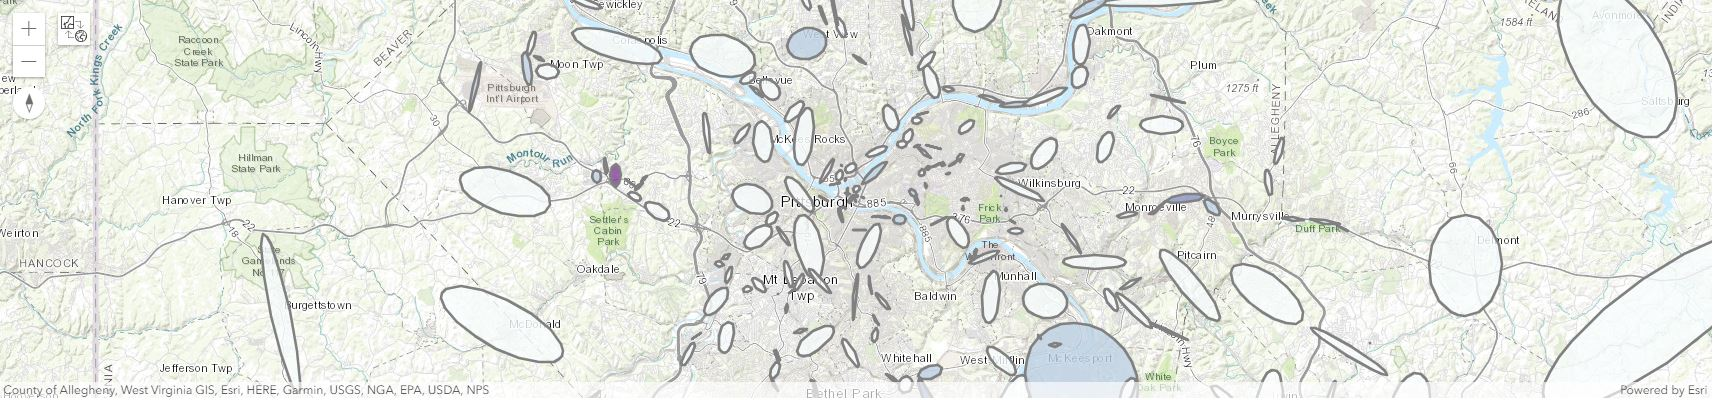

In [53]:
totalsales_map, totalsales_hist = create_map_and_histogram("Pittsburgh", summary_sdf, "sum_salesvol", cmap="BuPu")
totalsales_map

In [54]:
show(totalsales_hist)

#### Where are the ellipse zones with the highest average restaurant sales volumes?

In [55]:
meansales_map, meansales_hist = create_map_and_histogram("Pittsburgh", summary_sdf, "mean_salesvol", cmap="BuPu")
meansales_map

MapView(layout=Layout(height='400px', width='100%'))

In [56]:
show(meansales_hist)

Let's view some of the ellipse zones with the highest average restaurant sales volume by using a helper function (defined above in the 'setup' section)


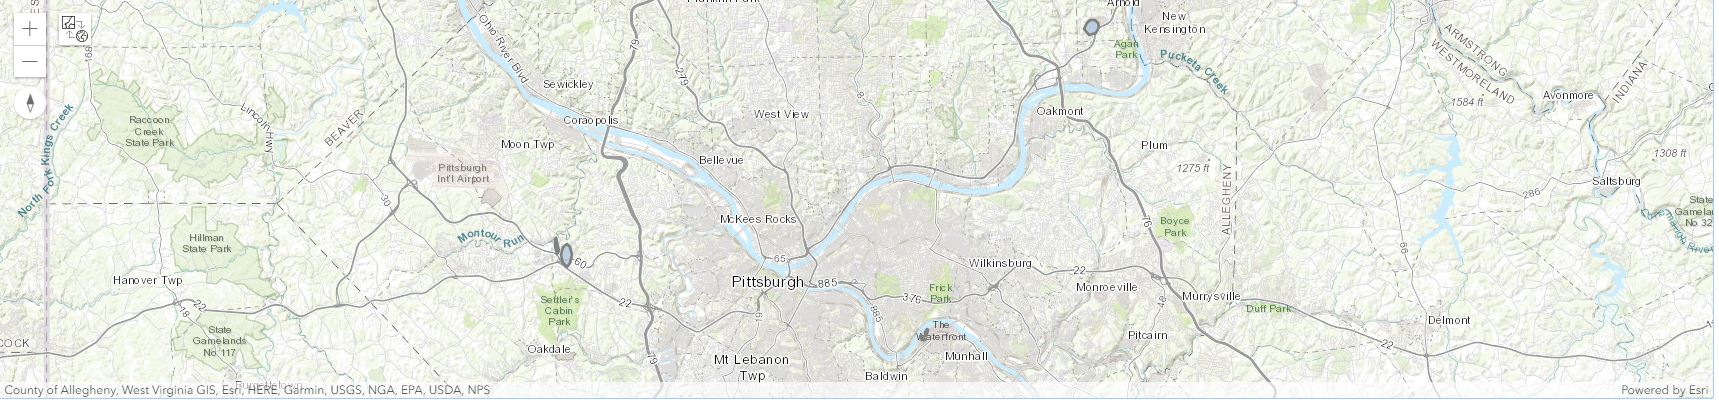

In [66]:
top_bin_map = gis.map("Pittsburgh")
summary_sdf.loc[summary_sdf['mean_salesvol']>2400].spatial.plot(top_bin_map, col='mean_salesvol', method='esriClassifyNaturalBreaks', class_count=5, cmap='BuPu', alpha=0.8)
top_bin_map

In [58]:
visit_ellipse_features_on_map_widget(top_bin_map, summary_sdf.loc[summary_sdf['mean_salesvol']>2400])

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


### B. Finding statistically significant clustering of restaurant sales volume features using Hot Spots

![Find Hot Spots](https://doc.arcgis.com/en/arcgis-online/analyze/GUID-D4A59131-AC88-4C7A-85BA-67861D5C1CF8-web.png)

To help us identify which clusters contain more successful restaurants, we will use the ["Find Hot Spots"](https://doc.arcgis.com/en/arcgis-online/analyze/find-hot-spots.htm#ESRI_SECTION1_09DAA5EA4B0B4F01991E9D904CA2B1B6) tool to identify statistically significant clustering of restaurants using their yearly sales volume as our analysis values. This time, we can use the analyze_patterns toolbox in the connected GIS. 

In [59]:
# Remove existing layer of restaurant hot spots (if one exists)
gis.content.delete_items(gis.content.search('restaurant_hotspots_01'))

# Run optimized hot spots, using sales volume as the analysis field
restaurant_hot_spots_item = features.analyze_patterns.find_hot_spots(restaurants_item, analysis_field='salesvol', output_name='restaurant_hotspots_01', gis=gis)


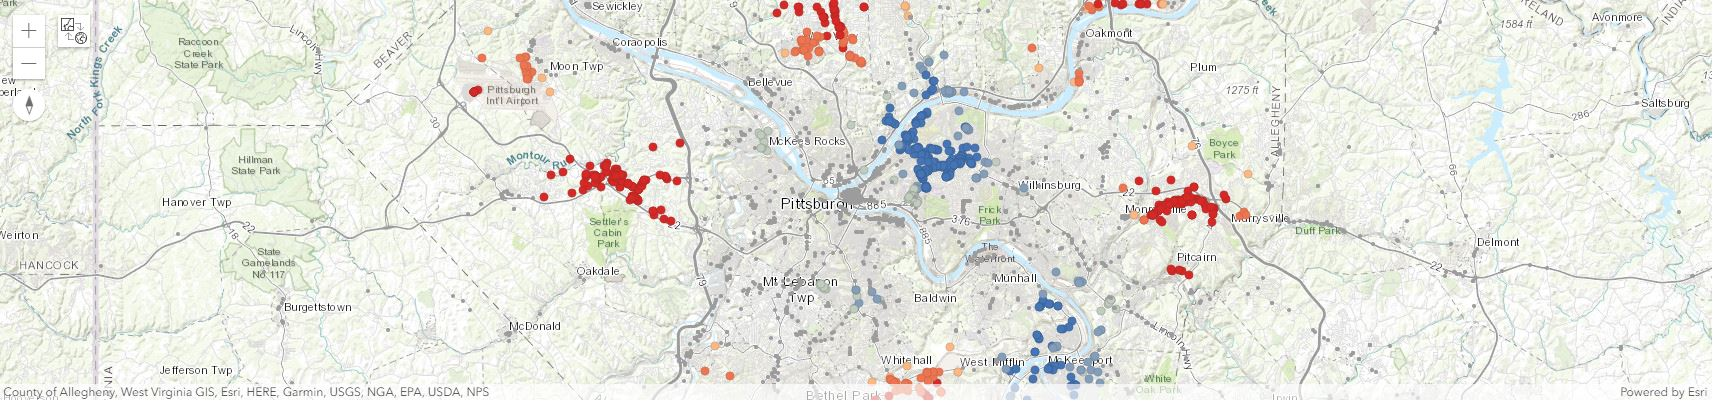

In [67]:
# Create a map of Pittsburgh to show hot spots outputs
hot_spots_map = gis.map("Pittsburgh")
hot_spots_map.add_layer(restaurant_hot_spots_item)
hot_spots_map.zoom = 10
hot_spots_map

Now let's bring back our spatially-enabled dataframe from our previous step summarize the statistics of the hot spots analysis for restaurants within each ellipse zone

In [61]:
gis.content.delete_items(gis.content.search("EllipseSummary02"))
# Calculate the sum of sales volume and the mean of sales volume
sum_fields = ['gi_bin Sum', 'gipvalue Sum', 'gizscore Sum', 'gi_bin Mean', 'gipvalue Mean', 'gizscore Mean']
# Run the calculation
sv_summary2 = summarize_data.aggregate_points(point_layer = restaurant_hot_spots_item.layers[0],
                                             polygon_layer = sv_summary.layers[0],
                                             summary_fields=sum_fields,
                                             output_name="EllipseSummary02"
                                            )
sv_summary2

<Item title:"EllipseSummary02" type:Feature Layer Collection owner:anieto001>

We can now make a map of the ellipse zones symbolized by the average gi bin, which represents the designation of hot spots, cold spots, or unsignificant spots. 


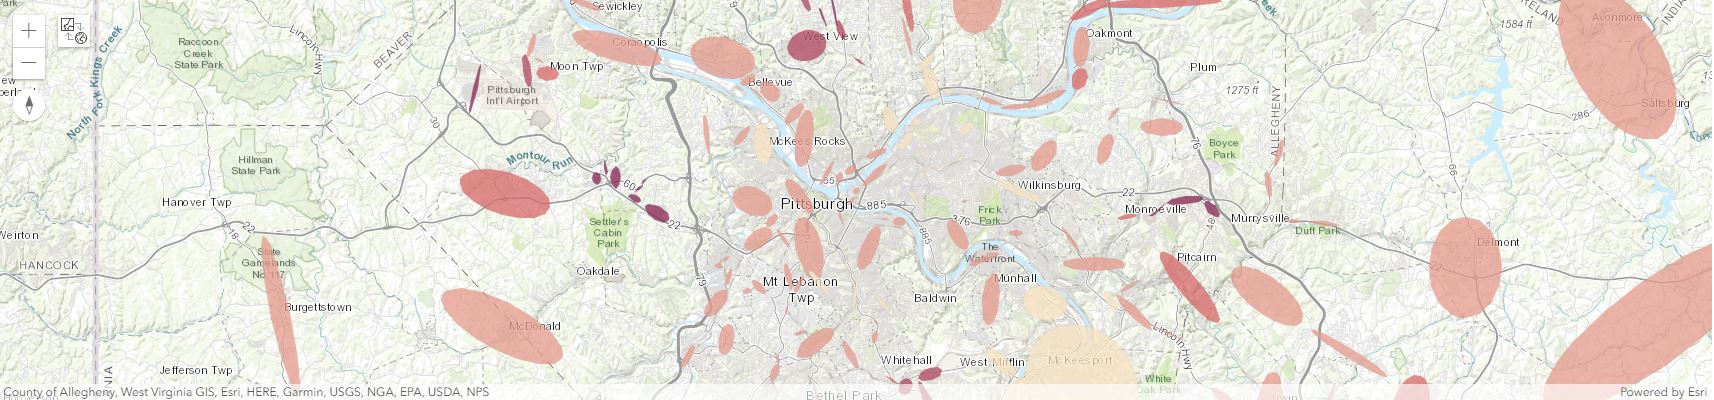

In [68]:
hotspot_ellipses_map = gis.map("Pittsburgh")
# summary2_sdf.spatial.plot(map_widget=hotspot_ellipses_map, col='mean_gi_bin', renderer_type='c', cmap='coolwarm', alpha=0.8)
hotspot_ellipses_map

In [63]:
hotspot_ellipses_map.add_layer(sv_summary2, {
    "renderer":"ClassedColorRenderer",
    "field_name":"mean_gi_bin",
    "classificationMethod":"ClassedColorRenderer",
    "opacity":0.75
})

Finally, let's convert our summary output for ellipse zones into a spatially-enabled dataframe so we can make our final priority assessment

In [69]:
# Convert the output item into a spatially-enabled dataframe
fset = sv_summary2.layers[0].query()
summary2_sdf = fset.sdf
summary2_sdf.head()

,SHAPE,analysisarea,centerx,centery,cluster_id,mean_gi_bin,mean_gipvalue,mean_gizscore,mean_salesvol,objectid,point_count,point_count_1,rotation,sum_gi_bin,sum_gipvalue,sum_gizscore,sum_salesvol,xstddist,ystddist
0,"{""rings"": [[[-8912514.427799998, 5024099.28689...",18.548609,-8.910530e+06,5.023269e+06,1,0.000000,0.725146,0.114444,792.111111,1,18,18.0,22.711797,0.0,13.052637,2.059989,14258.0,2151.586100,12525.834221
1,"{""rings"": [[[-8832192.777099999, 4966569.23970...",0.884207,-8.831966e+06,4.966738e+06,3,0.000000,0.318608,-0.997323,298.600000,2,5,5.0,143.274423,0.0,1.593038,-4.986617,1493.0,283.002577,4506.261331
2,"{""rings"": [[[-8835736.602800002, 4990278.83850...",147.530862,-8.825619e+06,4.985812e+06,2,0.000000,0.370132,-0.917133,208.153846,3,13,13.0,23.821812,0.0,4.811715,-11.922728,2706.0,11059.807891,19222.922180
3,"{""rings"": [[[-8894614.7559, 4991845.114300005]...",0.012757,-8.894847e+06,4.991924e+06,38,1.857143,0.007836,2.674614,580.857143,38,7,7.0,108.715687,13.0,0.054851,18.722297,4066.0,245.366324,75.027222
4,"{""rings"": [[[-8848978.753299998, 4984824.30430...",0.418115,-8.848780e+06,4.984781e+06,10,0.000000,0.104431,-1.631379,242.600000,4,5,5.0,12.375789,0.0,0.522155,-8.156897,1213.0,203.846151,2966.869552


### Calculating Priority Scores

We are now ready to assign a priority score for each ellipse zone based on basic restaurant sales volume statistics at each ellipse as well as the presence of hot spot/cold spot restaurant features within each zone. 

In order to help make this analysis flexible for further refinements, let's apply a weight to each of these factors. 

Factors:

- Amount of restaurants in zone: 0.75
- Average sales volume in zone: 1.0
- Average GI Bin score in zone: 2.0

The final priority score will be assessed as the normalized addition of each factor multiplied by its weight. The formula therefore is as follows:

P = 

In [70]:
# Establish weight values for each factor
priority_score_weights = {
    "restaurant count":0.75,
    "mean sales volume":1.0,
    "mean gi bin score": 2.0
}

In [71]:
# Establish a list of fields to compute z-scores for
list_of_fields_to_normalize = [
    'point_count',
    'mean_salesvol',
    'mean_gi_bin'
]

In [72]:
# Iterate on each field and calculate z-score
for field in list_of_fields_to_normalize:
    print("Calculating z-score for "+field)
    summary2_sdf[field+"_zscore"] = (summary2_sdf[field] - summary2_sdf[field].mean())/summary2_sdf[field].std(ddof=0)

Calculating z-score for point_count
Calculating z-score for mean_salesvol
Calculating z-score for mean_gi_bin


In [73]:
summary2_sdf.head()

,SHAPE,analysisarea,centerx,centery,cluster_id,mean_gi_bin,mean_gipvalue,mean_gizscore,mean_salesvol,objectid,...,rotation,sum_gi_bin,sum_gipvalue,sum_gizscore,sum_salesvol,xstddist,ystddist,point_count_zscore,mean_salesvol_zscore,mean_gi_bin_zscore
0,"{""rings"": [[[-8912514.427799998, 5024099.28689...",18.548609,-8.910530e+06,5.023269e+06,1,0.000000,0.725146,0.114444,792.111111,1,...,22.711797,0.0,13.052637,2.059989,14258.0,2151.586100,12525.834221,1.005862,-0.012326,-0.085496
1,"{""rings"": [[[-8832192.777099999, 4966569.23970...",0.884207,-8.831966e+06,4.966738e+06,3,0.000000,0.318608,-0.997323,298.600000,2,...,143.274423,0.0,1.593038,-4.986617,1493.0,283.002577,4506.261331,-0.899938,-0.923560,-0.085496
2,"{""rings"": [[[-8835736.602800002, 4990278.83850...",147.530862,-8.825619e+06,4.985812e+06,2,0.000000,0.370132,-0.917133,208.153846,3,...,23.821812,0.0,4.811715,-11.922728,2706.0,11059.807891,19222.922180,0.272862,-1.090562,-0.085496
3,"{""rings"": [[[-8894614.7559, 4991845.114300005]...",0.012757,-8.894847e+06,4.991924e+06,38,1.857143,0.007836,2.674614,580.857143,38,...,108.715687,13.0,0.054851,18.722297,4066.0,245.366324,75.027222,-0.606738,-0.402391,1.420862
4,"{""rings"": [[[-8848978.753299998, 4984824.30430...",0.418115,-8.848780e+06,4.984781e+06,10,0.000000,0.104431,-1.631379,242.600000,4,...,12.375789,0.0,0.522155,-8.156897,1213.0,203.846151,2966.869552,-0.899938,-1.026960,-0.085496


In [74]:
# Define a helper function to calculate the Priority Score
def calculate_priority_score(point_count, mean_salesvol, mean_gi_bin):
    score_val = float((float(point_count) * priority_score_weights['restaurant count']) + (float(mean_salesvol) * priority_score_weights['mean sales volume']) + (float(mean_gi_bin) * priority_score_weights['mean gi bin score']))
    return score_val

In [75]:
summary2_sdf['priority_score'] = summary2_sdf.apply(lambda x: calculate_priority_score(x['point_count_zscore'], x['mean_salesvol_zscore'], x['mean_gi_bin_zscore']), axis=1)
summary2_sdf['ps_zscore'] = (summary2_sdf['priority_score'] - summary2_sdf['priority_score'].mean())/summary2_sdf['priority_score'].std(ddof=0)
summary2_sdf.head()

,SHAPE,analysisarea,centerx,centery,cluster_id,mean_gi_bin,mean_gipvalue,mean_gizscore,mean_salesvol,objectid,...,sum_gipvalue,sum_gizscore,sum_salesvol,xstddist,ystddist,point_count_zscore,mean_salesvol_zscore,mean_gi_bin_zscore,priority_score,ps_zscore
0,"{""rings"": [[[-8912514.427799998, 5024099.28689...",18.548609,-8.910530e+06,5.023269e+06,1,0.000000,0.725146,0.114444,792.111111,1,...,13.052637,2.059989,14258.0,2151.586100,12525.834221,1.005862,-0.012326,-0.085496,0.571080,0.210492
1,"{""rings"": [[[-8832192.777099999, 4966569.23970...",0.884207,-8.831966e+06,4.966738e+06,3,0.000000,0.318608,-0.997323,298.600000,2,...,1.593038,-4.986617,1493.0,283.002577,4506.261331,-0.899938,-0.923560,-0.085496,-1.769504,-0.668705
2,"{""rings"": [[[-8835736.602800002, 4990278.83850...",147.530862,-8.825619e+06,4.985812e+06,2,0.000000,0.370132,-0.917133,208.153846,3,...,4.811715,-11.922728,2706.0,11059.807891,19222.922180,0.272862,-1.090562,-0.085496,-1.056907,-0.401031
3,"{""rings"": [[[-8894614.7559, 4991845.114300005]...",0.012757,-8.894847e+06,4.991924e+06,38,1.857143,0.007836,2.674614,580.857143,38,...,0.054851,18.722297,4066.0,245.366324,75.027222,-0.606738,-0.402391,1.420862,1.984278,0.741334
4,"{""rings"": [[[-8848978.753299998, 4984824.30430...",0.418115,-8.848780e+06,4.984781e+06,10,0.000000,0.104431,-1.631379,242.600000,4,...,0.522155,-8.156897,1213.0,203.846151,2966.869552,-0.899938,-1.026960,-0.085496,-1.872904,-0.707545


In [76]:
# Clean-up
top_zones_sdf = summary2_sdf
del(summary2_sdf, summary_sdf)

In [77]:
top_zones_sdf.shape[0]

346

In [78]:
# Clean up score field
top_zones_sdf = top_zones_sdf[np.isfinite(top_zones_sdf['ps_zscore'])]
top_zones_sdf.shape[0]

343

We're ready to make a map of the top restaurant zones by this approach!

## Where are the top five restaurants zones by priority score?

In [79]:
top_zones_sdf = top_zones_sdf.sort_values(by=['ps_zscore'], ascending=False)
top_zones_sdf.head()

,SHAPE,analysisarea,centerx,centery,cluster_id,mean_gi_bin,mean_gipvalue,mean_gizscore,mean_salesvol,objectid,...,sum_gipvalue,sum_gizscore,sum_salesvol,xstddist,ystddist,point_count_zscore,mean_salesvol_zscore,mean_gi_bin_zscore,priority_score,ps_zscore
191,"{""rings"": [[[-8923969.6808, 4931619.720500007]...",0.246452,-8.923561e+06,4.931611e+06,195,3.000000,0.000000,7.017320,2983.478261,192,...,0.000000,161.398354,68620.0,409.214909,858.433274,1.738863,4.033882,2.347851,10.033730,3.764961
168,"{""rings"": [[[-8878566.901399996, 4930031.79890...",0.308486,-8.880020e+06,4.929855e+06,172,3.000000,0.000345,3.604876,1129.810811,169,...,0.012779,133.380401,41803.0,1464.277838,300.290419,3.791263,0.611214,2.347851,8.150362,3.057508
233,"{""rings"": [[[-8900012.484800002, 4914279.40649...",0.465287,-8.899673e+06,4.914428e+06,238,2.909091,0.000785,3.452746,2068.636364,234,...,0.017271,75.960412,45510.0,370.947179,1782.304999,1.592263,2.344690,2.274113,8.087112,3.033750
209,"{""rings"": [[[-8906974.288499996, 4944424.78289...",0.116985,-8.906857e+06,4.944448e+06,214,3.000000,0.000466,3.535763,2249.000000,210,...,0.005587,42.429151,26988.0,119.583783,1401.524338,0.126262,2.677719,2.347851,7.468117,2.801236
188,"{""rings"": [[[-8925355.079699999, 4931457.12089...",0.118014,-8.925014e+06,4.931537e+06,192,3.000000,0.000000,7.214493,1993.562500,189,...,0.000000,115.431885,31897.0,350.478996,479.921752,0.712662,2.206071,2.347851,7.436269,2.789273



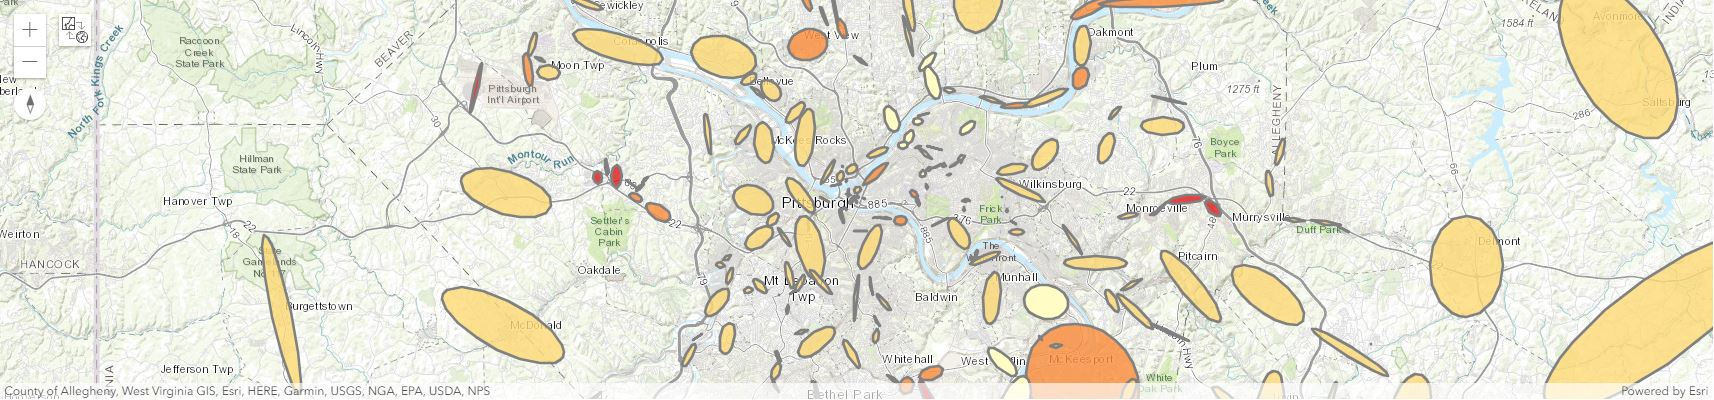

In [81]:
top_zones_map, top_zones_hist = create_map_and_histogram("Pittsburgh", top_zones_sdf, "ps_zscore", cmap='YlOrRd')
top_zones_map

In [82]:
show(top_zones_hist)

In [83]:
# Top five ellipse zones
top_zones_sdf.head()

,SHAPE,analysisarea,centerx,centery,cluster_id,mean_gi_bin,mean_gipvalue,mean_gizscore,mean_salesvol,objectid,...,sum_gipvalue,sum_gizscore,sum_salesvol,xstddist,ystddist,point_count_zscore,mean_salesvol_zscore,mean_gi_bin_zscore,priority_score,ps_zscore
191,"{""rings"": [[[-8923969.6808, 4931619.720500007]...",0.246452,-8.923561e+06,4.931611e+06,195,3.000000,0.000000,7.017320,2983.478261,192,...,0.000000,161.398354,68620.0,409.214909,858.433274,1.738863,4.033882,2.347851,10.033730,3.764961
168,"{""rings"": [[[-8878566.901399996, 4930031.79890...",0.308486,-8.880020e+06,4.929855e+06,172,3.000000,0.000345,3.604876,1129.810811,169,...,0.012779,133.380401,41803.0,1464.277838,300.290419,3.791263,0.611214,2.347851,8.150362,3.057508
233,"{""rings"": [[[-8900012.484800002, 4914279.40649...",0.465287,-8.899673e+06,4.914428e+06,238,2.909091,0.000785,3.452746,2068.636364,234,...,0.017271,75.960412,45510.0,370.947179,1782.304999,1.592263,2.344690,2.274113,8.087112,3.033750
209,"{""rings"": [[[-8906974.288499996, 4944424.78289...",0.116985,-8.906857e+06,4.944448e+06,214,3.000000,0.000466,3.535763,2249.000000,210,...,0.005587,42.429151,26988.0,119.583783,1401.524338,0.126262,2.677719,2.347851,7.468117,2.801236
188,"{""rings"": [[[-8925355.079699999, 4931457.12089...",0.118014,-8.925014e+06,4.931537e+06,192,3.000000,0.000000,7.214493,1993.562500,189,...,0.000000,115.431885,31897.0,350.478996,479.921752,0.712662,2.206071,2.347851,7.436269,2.789273



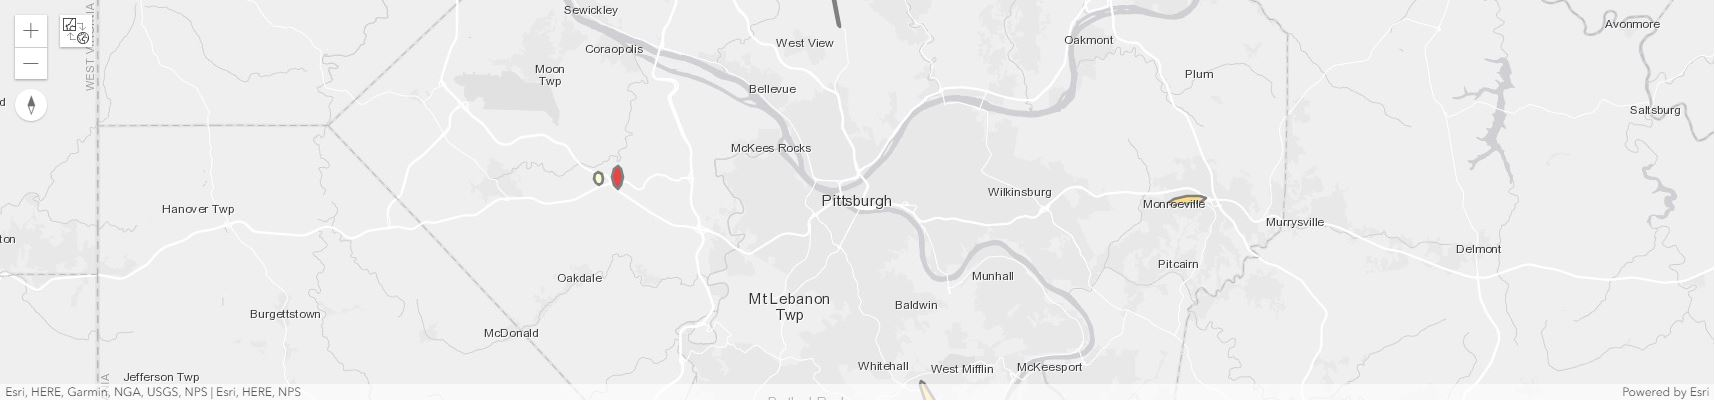

In [87]:
# Map of top five ellipse zones
top_five_map, top_five_hist = create_map_and_histogram("Pittsburgh", top_zones_sdf.head(), "ps_zscore", cmap='YlOrRd')
top_five_map.basemap='gray'
top_five_map

In [85]:
# Execute this cell to tour each of the five zones selected
visit_ellipse_features_on_map_widget(top_five_map, top_zones_sdf.head())

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


To make all of the analysis available for further refinement, the following cell adds each layer that was used in this process. It's quite ugly, but it contains every component we used. 


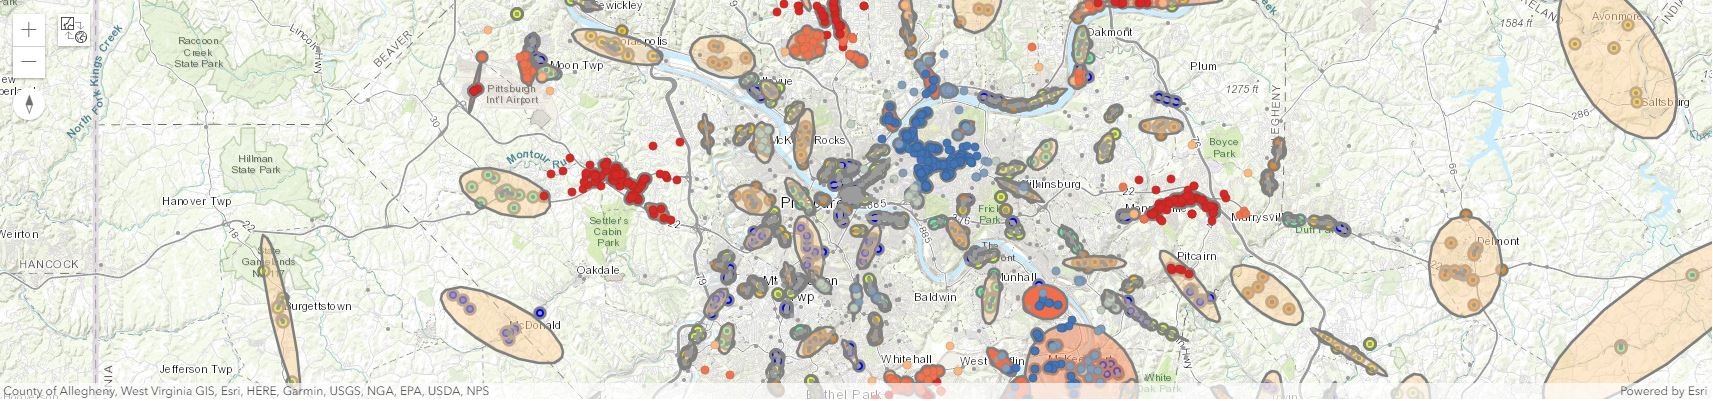

In [89]:
full_analysis_map = gis.map("Pittsburgh")
# Add the Hot Spots outputs to the map
full_analysis_map.add_layer(restaurant_hot_spots_item)
# Add the clustered restaurants to the map
clusters_sdf.spatial.plot(map_widget=full_analysis_map, renderer_type='u', col="COLOR_ID")
# Add the summary elipse zones
top_zones_sdf.spatial.plot(map_widget=full_analysis_map, renderer_type='c', method='esriClassifyNaturalBreaks', class_count=5, cmap='OrRd', col='ps_zscore', alpha=0.5)
# Show the full analysis map
full_analysis_map

# <span style="color:purple">4) Present the Results:</span> 

To present these results, we'll create web maps and a Story Map Journal with sections provided by each of our top five ellipsoid zones (determined by the priority score). 

In [90]:
# Create web map properties and use the web map widget's save method
webmap_properties = {'title': 'Pittsburgh Restaurant Zone Prospecting - Web Map v1',
                     'snippet': 'Web Map from clustering analysis of restaurants.',
                     'tags': ['automation', 'python']}
top_zones_webmap_item = top_zones_map.save(webmap_properties)
top_zones_webmap_item

<Item title:"Pittsburgh Restaurant Zone Prospecting - Web Map v1" type:Web Map owner:anieto001>

In [91]:
# Create web map properties and use the web map widget's save method
webmap_properties = {'title': 'Pittsburgh Restaurant Zone Prospecting - Full Analysis Web Map v1',
                     'snippet': 'Web Map from clustering analysis of restaurants.',
                     'tags': ['automation', 'python']}
full_analysis_webmap_item = full_analysis_map.save(webmap_properties)
full_analysis_webmap_item

<Item title:"Pittsburgh Restaurant Zone Prospecting - Full Analysis Web Map v1" type:Web Map owner:anieto001>

## Please Note: The section below is still under construction.

The ArcGIS API for Python contains an apps module, with a storymap class. We can leverage this to create the Story Map journal from this hosted notebook.

Let's start by instantiating the story map object, passing it an ID of a story map journal template with no content. 

In [ ]:
# Create story map journal with outputs
storymap = arcgis.apps.storymap.JournalStoryMap(item="4b6911a4332a4661bdd89688ade8f04c", gis=gis)
storymap

Now we can iterate on each site, store a web map, and add it to a section in the Story Map journal with descriptive content.

In [ ]:
storymap_map = gis.map("Pittsburgh")
storymap_map.basemap = 'gray'
clusters_sdf.spatial.plot(map_widget=storymap_map, renderer_type='u', col='CLUSTER_ID')
top_zones_sdf.head().spatial.plot(map_widget=storymap_map, alpha=0.5)
storymap_map

In [ ]:
# Helper function to change the web map widget extent to each provided ellipse zone
def change_webmap_widget_extent(m, point, zoom_level=15):
    m.zoom = zoom_level
    projected_point = project([point], in_sr=3857, out_sr=4326)
    m.center = [projected_point[0]['y'], projected_point[0]['x']]

In [ ]:
storymap_map# Iterate on each of the top five zones for the story map journal sections
counter=0
for index, row in top_clusters_sdf.head().iterrows():
    counter+=1
    print("Adding section {0}...".format(str(counter)))
    
    # Visit site (i.e. set web map widget extent to site)
    change_webmap_widget_extent(storymap_map, row['center_xy'])
    time.sleep(5)
    
    # Store web map on GIS
    webmap_properties = {'title': 'Pittsburgh Restaurant Prospecting: Site {0}'.format(str(counter)),
                         'snippet': 'Web Map from clustering analysis of restaurants.',
                         'tags': ['automation', 'python']}
    site_webmap_item = storymap_map.save(webmap_properties)
    
    section_content = "Average Yearly Sales Volume in Zone: {0}".format(str(round("{:,}".format(row['mean_salesvol']), 2)))
    
    # Add section to storymap object, using the web map ID
    storymap._add_webmap(item= site_webmap_item.id, 
                         title="Pittsburgh Restaurant Prospecting: Site {0}".format(str(counter)),
                         content=section_content,
                         actions=None, visible=True,
                         alt_text="", display='stretch')
    storymap.save(title="AutoStoryMap01", tags="automation", description="auto storymap")
    time.sleep(2)